# Movie Analysis Project
## By Clare Casey and Hannah Vollan Cole

# Notebook Information:
### Introduction
### Data gathering and cleaning
### Preliminary data analysis
### Classification and graphs
### Results and Discussion

# Introduction and Dataset Description
Our dataset is actually two datasets. The IMDb movies, which is a dataset of 85855 movies with their title names, year of release, date of release, movie genres, duration (in minutes), movie country, movie language, and director name. There are more datasets within this dataset, which include total weighted average rating, total votes recieved, total mean vote, total median vote, and the number of votes of ratings equal to a certain number.

The second dataset has the names of the movies, years and whether or not the movie was a nominee or winner of the Oscar award for the best picture.

Our plan is to create a combined dataset with a new attribute, Oscar status, which will be able to be winner, nominee or not nominated. We will write a modified join fucntion that adds this new attribute to the IMDb movie dataset.

We will try to predict the Oscar status of each movie, and then create a test set with information about movies from this year to see if we can accurately predict whether a movie will be nominated or win the Best Picture Oscar.

https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv
https://www.kaggle.com/amandaiglesias/oscar-winners-and-nominees

In [2]:
# some useful mysklearn package import statements and reloads
import importlib
import random
import copy
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForest, MyRandomClassifier, MyZeroClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation
all_films_table = MyPyTable().load_from_file("input_data/all_films_cleaned.csv")
oscar_table = MyPyTable().load_from_file("input_data/oscars.csv")

## Data Preparation and Cleaning 

We first looked at the large dataset, which has approximately 85,000 instances, and looked for ways to trim the size. We trimmed a number of instances that included movies made before 1926. The data on Oscar wins and nominations only goes back to 1927, so earlier data would skew the tree, as they would be automatic snubbs. The colomuns we deleted are: "budget" "usa_gross_income", "worldwide_gross_income", "metascore", and "description". These columns contained too many missing values to be useful.

We created a MyPyTable for each of the two files, "all_films.csv" and "oscars.csv". We then retrieved the data from the MyPyTables, edited them, and joined them. This new data table that includes the data and class label of "winner", "nominee", or "snubbed", was written into a new file called "film_data.csv". 

(Look at films with high IMDB, group by genre, subsampling within genre, budget; check second dataset)

We removed a lot of different parts of the data, including all movies not made in the USA, films with reviews less than 6, movies with fewer than 800 reviews, movies that are less than 90 minutes long, films that have fewer than 50 reviews by critics and users, and movies where English is not one of the languages. 

## Attribute Labels

IMDB title ID, Title, Original title, Year, Date Published, Genre, Duration (in minutes), Country, Language, Director, Writer, Production company, Actors, Average vote, Total number of votes, Amount of reviews from users, Amount of reviews from critics, Oscar status

We will be predicting Oscar Status, which is an attribute we create from the union of a dataset of all the Oscar winners and nominees.

In [3]:
all_films = copy.deepcopy(all_films_table.data)
all_films_id = all_films_table.get_column("imdb_title_id")
oscar_noms = copy.deepcopy(oscar_table.data)
oscar_status = oscar_table.get_column("Position")
id_num = oscar_table.get_column("id_imdb")

all_films_table.column_names.append("oscar_status")
header = copy.deepcopy(all_films_table.column_names)

for film in all_films:
    # get rid of leading 't's from the id index in all_films
    film[0] = int(film[0].replace('t', ''))

# find if the film was a winner, nominated, or snubbed
# append a new column to each row with class label
for film in all_films:
    if film[0] in id_num:
        id_index = id_num.index(film[0])
        film.append(oscar_status[id_index])
    else:
        film.append("Snubbed")

# drop rows with low reviews
all_films_edit = []
for film in all_films:
    if film[13] > 6:
        all_films_edit.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit.append(film)

In [4]:
# drop rows not made in the USA
all_films_edit2 = []
for film in all_films_edit:
    if type(film[3]) == str:
        pass
    elif "USA" in film[7]:
        #film[7] = "USA"
        all_films_edit2.append(film)
    # keeps the few foreign movies that were nominated for the oscar before 2000
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit2.append(film)

# drop rows with fewer than 800 reviews
all_films_edit3 = []
for film in all_films_edit2:
    if type(film[14]) == str or film[14] == '':
        pass
    elif int(film[14]) > 800:
        all_films_edit3.append(film)    
    # keeps the movies nominated for an oscar
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit3.append(film)

# drops movies that are less than 90 minutes long
all_films_edit4 = []
for film in all_films_edit3:
    if int(film[6]) > 90:
        all_films_edit4.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit4.append(film)

# drops films that have fewer than 50 reviews by critics and users
all_films_edit5 = []
for film in all_films_edit4:
    if type(film[15]) == str or film[15] == '':
        pass
    elif type(film[16]) == str or film[16] == '':
        pass
    elif film[15] > 50 and film[16] > 50:
        all_films_edit5.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit5.append(film)

# drop rows where English is not one of the languages
all_films_edit6 = []
for film in all_films_edit5:
    if "English" in film[8]:
        #film[8] = "English"
        all_films_edit6.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit6.append(film)

myutils.reviews_to_categorical(all_films_edit6, 15)
myutils.reviews_to_categorical(all_films_edit6, 16)
myutils.num_ratings_to_categorical(all_films_edit6, 14)
myutils.avg_votes_to_categorical(all_films_edit6, 13)
film_data = MyPyTable(header, all_films_edit6)
film_data.save_to_file("input_data/film_data.csv")

## Figure 1: Class Label Pie Chart

Figure 1 shows the distribution of different class labels throughout our dataset as shown by a pie chart.

{'Snubbed': 3321, 'Nominee': 463, 'Winner': 91}


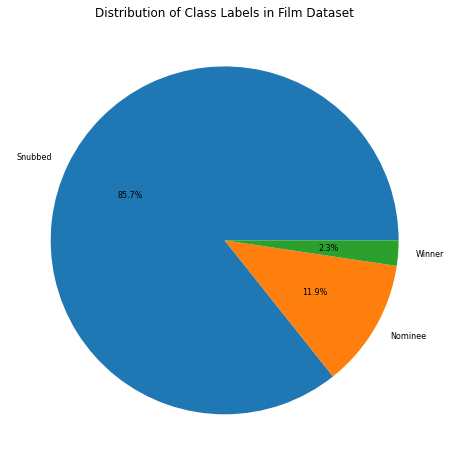

In [5]:
class_labels = copy.deepcopy(film_data.get_column("oscar_status"))
freq_dict = myutils.create_dictionary(class_labels)
names = list(freq_dict.keys())
freqs = list(freq_dict.values())

print(freq_dict)
plot_utils.make_pie_chart_with_comp(names, freqs, "Distribution of Class Labels in Film Dataset")

## Initial EDA on "film_data.csv"

### Pie Chart of Class Labels

## Figure 2: Histogram of Film Genres

Figure 2 shows the different amounts of different film genres within our dataset.

The "genre" column of data is a string that contains one or more genre names. This would not be handled well by our plot utils. Therefore, we searched the string for a substring, genre name in genre_lst, and if the substring was found, we appended it to a list. 

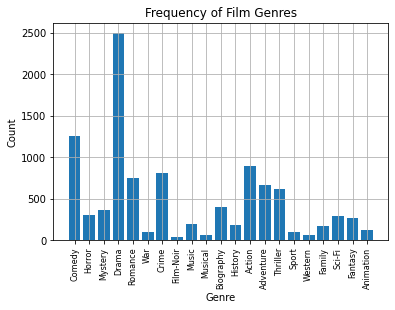

In [6]:
# list of possible genres
genre_lst = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime","Documentary", "Drama", "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", "Mystery", "News", "Romance", "Sci-Fi", "Sport", "Thriller", "Western", "War"]
genre_col = copy.deepcopy(film_data.get_column("genre"))
genres = []
for row in genre_col:
    for item in genre_lst:
        if row.find(item) != -1:
            genres.append(item)

plot_utils.make_bar_graph_with_column(genres, "Frequency of Film Genres", "Genre", "Count", 8)

## Figure 3: Histogram of Film Production Companies

Figure 3 is a histogram that represents the amount of times the top 20 production companies are represented in the dataset.

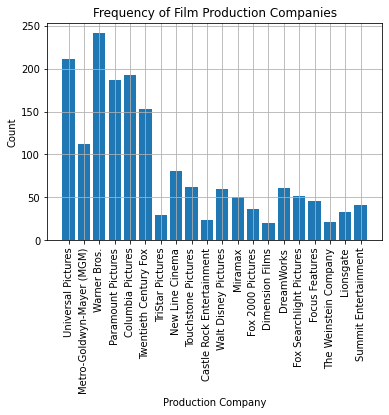

In [7]:
# list of all possible production companies
production_company_lst2 = []
production_company_counts = []
production_company_lst = []
production_counts = []
production_col = copy.deepcopy(film_data.get_column("production_company"))
production_companies = []
for company in production_col:
    if company not in production_company_lst:
        production_company_lst.append(company)
        production_counts.append(1)
    else:
        company_index = production_company_lst.index(company)
        production_counts[company_index] += 1

# adds the most common production companies to the production_company_lst2
for i in range(len(production_counts)):
    if production_counts[i] > 19:
        production_company_lst2.append(production_company_lst[i])
        production_company_counts.append(production_counts[i])

plot_utils.make_bar_graph_with_xy(production_company_lst2, production_company_counts, "Frequency of Film Production Companies", "Production Company", "Count", 10)

## Figure 4: Scatter Plot that shows the Average Rating Compared to the Number of Ratings

Figure 4 is a scatter plot that plots the average rating of a movie to against the total number of ratings for that movie. The values beneath 6 are very sparse because we removed all movies with ratings below six that were not nominated or did not win an oscar. 

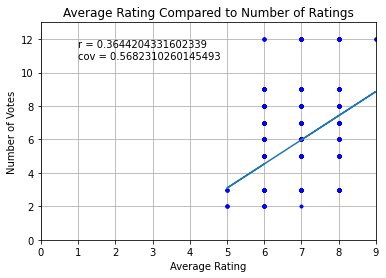

In [8]:
plot_utils.make_scatter_plot(film_data, "avg_vote", "votes", "Average Rating Compared to Number of Ratings", "Average Rating", "Number of Votes")

## Figure 5: Scatter Plot Comparing Amount of User Reviews to Amount of Reviews from Critics

Figure 5 plots the amount of user reviews on the x-axis and the amount of critic reviews on the y-axis. It also includes a line for the covariance between these two lists of values. 

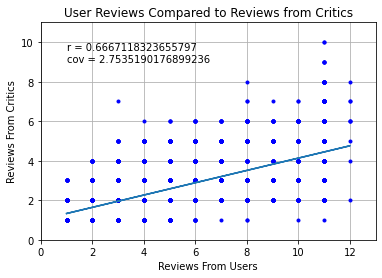

In [9]:
plot_utils.make_scatter_plot(film_data, "reviews_from_users", "reviews_from_critics", "User Reviews Compared to Reviews from Critics", "Reviews From Users", "Reviews From Critics")

# Naive Bayes Classifier 

In [10]:
NaiveBayes = MyNaiveBayesClassifier()
X = []
y = []
data_table = copy.deepcopy(film_data)
data_table.remove_rows_with_missing_values()
data = copy.deepcopy(data_table.data)
for row in data:
    new_row = []
    y.append(row[-1])
    for item in row[:17]:
        new_row.append(item)
    X.append(new_row)
X_half = []
y_half = []
for i in range(int((len(X)/2)), (len(X))):
    X_half.append(X[i])
    y_half.append(y[i])
X_half_edit = []
for i in range(len(X_half)):
    new_row = []
    for j in range(len(X_half[0])):
        if j != 0:
            if j!= 1:
                if j!= 2:
                    if j!= 3:
                        if j!= 4:
                            if j!= 5:  
                                if j!= 9:
                                    if j!= 10:
                                        if j!= 11:
                                            if j!= 12:
                                                new_row.append(X_half[i][j])
    X_half_edit.append(new_row)
X_train, X_test, y_train, y_test = myevaluation.train_test_split(X_half_edit, y_half)
NaiveBayes.fit(X_train, y_train)
predicted = NaiveBayes.predict(X_test)
myevaluation.confusion_matrix(y_test, predicted, ["Winner", "Nominee", "Snubbed"])

[[1, 3, 2], [2, 11, 20], [0, 36, 565]]

## Figure 6: Confusion Matrix Interpretation

Figure 6 shows the bar graph interpretation of the confusion matrix that is shows the Naive Bayes result on this dataset. This predicts snubbed movies with great accuracy, but can not predict a single winner correctly. 

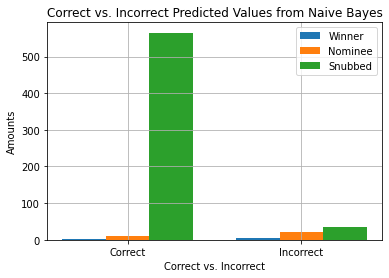

In [11]:
win_vals = myevaluation.confusion_matrix(y_test, predicted, ["Winner", "Nominee", "Snubbed"])[0]
nominee_vals = myevaluation.confusion_matrix(y_test, predicted, ["Winner", "Nominee", "Snubbed"])[1]
snubbed_vals = myevaluation.confusion_matrix(y_test, predicted, ["Winner", "Nominee", "Snubbed"])[2]
correct_win_vals = win_vals[0]
incorrect_win_vals = win_vals[1] + win_vals[2]
w_vals = [correct_win_vals, incorrect_win_vals]
correct_nom_vals = nominee_vals[1]
incorrect_nom_vals = nominee_vals[0] + nominee_vals[2]
n_vals = [correct_nom_vals, incorrect_nom_vals]
correct_snubbed_vals = snubbed_vals[2]
incorrect_snubbed_vals = snubbed_vals[1] + snubbed_vals[0]
s_vals = [correct_snubbed_vals, incorrect_snubbed_vals]
vals = ["Correct", "Incorrect"]


plot_utils.make_triple_bar_graphs(vals, w_vals, n_vals, s_vals, "Correct vs. Incorrect Predicted Values from Naive Bayes", "Correct vs. Incorrect", "Amounts", "Winner", "Nominee", "Snubbed")

## Figure 7: Bar Chart of y_test and predicted values of the Naive Bayes Classifier

Figure 7 shows the values of y_test juxtaposed against the predicted values of each class label, based on what the Naive Bayes classifier predicted for each class label. 

actual:  {'Winner': 6, 'Nominee': 33, 'Snubbed': 601}
predicted:  {'Winner': 3, 'Nominee': 50, 'Snubbed': 587}


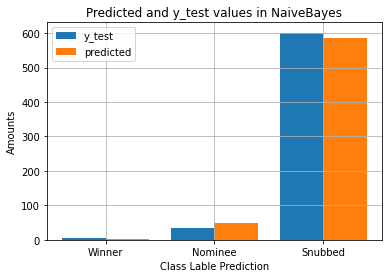

Percent Correct:  0.9015625


In [20]:
labels = ["Winner", "Nominee", "Snubbed"]

naive_bayes_test_labels = copy.deepcopy(y_test[0:5000])
test_dict = myutils.create_dictionary_labels(naive_bayes_test_labels, labels)
print("actual: ", test_dict)
lst1_vals = list(test_dict.keys())
lst1_counts = list(test_dict.values())

naive_bayes_predicted_labels = copy.deepcopy(predicted[0:5000])
predicted_dict = myutils.create_dictionary_labels(naive_bayes_predicted_labels, labels)
print("predicted: ", predicted_dict)
lst2_vals = list(predicted_dict.keys())
lst2_counts = list(predicted_dict.values())


plot_utils.make_multiple_bar_graphs(lst1_vals, lst2_vals, lst1_counts, lst2_counts, "Predicted and y_test values in NaiveBayes", "Class Lable Prediction", "Amounts", "y_test", "predicted")

percent_correct = myutils.get_percent_correct(predicted, y_test)
print("Percent Correct: ", percent_correct)

# Decision Trees

## Figure 8: Bar Chart of y_test and predicted values of the Decision Tree Classifier


actual {'Winner': 6, 'Nominee': 33, 'Snubbed': 601}
predicted {'Winner': 0, 'Nominee': 3, 'Snubbed': 523}


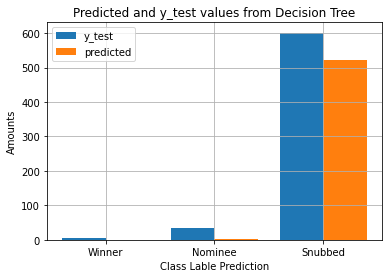

Percent Correct:  0.778125


In [19]:
DecisionTree = MyDecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
predict_1 = DecisionTree.predict(X_test)

test_dict = myutils.create_dictionary_labels(y_test, ["Winner", "Nominee", "Snubbed"])
print("actual", test_dict)
lst1_vals = list(test_dict.keys())
lst1_counts = list(test_dict.values())

predicted_dict = myutils.create_dictionary_labels(predict_1, ["Winner", "Nominee", "Snubbed"])
print("predicted", predicted_dict)
lst2_vals = list(predicted_dict.keys())
lst2_counts = list(predicted_dict.values())


plot_utils.make_multiple_bar_graphs(lst1_vals, lst2_vals, lst1_counts, lst2_counts, "Predicted and y_test values from Decision Tree", "Class Lable Prediction", "Amounts", "y_test", "predicted")

percent_correct = myutils.get_percent_correct(predict_1, y_test)
print("Percent Correct: ", percent_correct)


## Figure 9: Bar Chart of correct and incorrect predictions for the Decision Tree Classifier

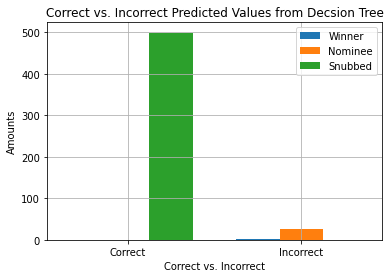

In [14]:
win_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[0]
nominee_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[1]
snubbed_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[2]
correct_win_vals = win_vals[0]
incorrect_win_vals = win_vals[1] + win_vals[2]
w_vals = [correct_win_vals, incorrect_win_vals]
correct_nom_vals = nominee_vals[1]
incorrect_nom_vals = nominee_vals[0] + nominee_vals[2]
n_vals = [correct_nom_vals, incorrect_nom_vals]
correct_snubbed_vals = snubbed_vals[2]
incorrect_snubbed_vals = snubbed_vals[1] + snubbed_vals[0]
s_vals = [correct_snubbed_vals, incorrect_snubbed_vals]
vals = ["Correct", "Incorrect"]


plot_utils.make_triple_bar_graphs(vals, w_vals, n_vals, s_vals, "Correct vs. Incorrect Predicted Values from Decsion Tree", "Correct vs. Incorrect", "Amounts", "Winner", "Nominee", "Snubbed")

# Random Forest
## Figure 10: Bar Chart of y_test and predicted values of the Random Forest Classifier

actual {'Winner': 6, 'Nominee': 33, 'Snubbed': 601}
predicted {'Winner': 0, 'Nominee': 9, 'Snubbed': 631}


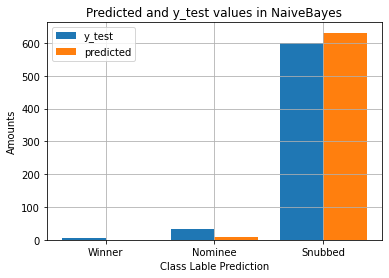

Percent Correct:  0.940625


In [15]:
header = ["duration", "country", "language", "avg_vote", "votes", "reviews_from_users", "reviews_from_critics"]

# get test and train sets using stratified_test_remainder to get the indices
RandomForest = MyRandomForest()
test_set_indices, remainder_set_indices = myevaluation.stratified_test_remainder(X_half_edit, y_half) 
X_train2 = []
y_train2 = []
for item in remainder_set_indices:
    X_train2.append(X_half_edit[item])  
    y_train2.append(y_half[item]) 
X_test2 = []
y_test2 = []
for item in test_set_indices:
    X_test2.append(X_half_edit[item])  
    y_test2.append(y_half[item]) 

# classify with random forest
RandomForest = MyRandomForest() 
RandomForest.fit(X_train2, y_train2, 20, 10, 4, header)
predict_1 = RandomForest.predict(X_test)
test_dict = myutils.create_dictionary_labels(y_test, ["Winner", "Nominee", "Snubbed"])
predicted_dict = myutils.create_dictionary_labels(predict_1, ["Winner", "Nominee", "Snubbed"])

# confusion matrix
myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])

# dictionaries and bar chart
test_dict = myutils.create_dictionary_labels(y_test, ["Winner", "Nominee", "Snubbed"])
print("actual", test_dict)
lst1_vals = list(test_dict.keys())
lst1_counts = list(test_dict.values())

predicted_dict = myutils.create_dictionary_labels(predict_1, ["Winner", "Nominee", "Snubbed"])
print("predicted", predicted_dict)
lst2_vals = list(predicted_dict.keys())
lst2_counts = list(predicted_dict.values())

myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])

plot_utils.make_multiple_bar_graphs(lst1_vals, lst2_vals, lst1_counts, lst2_counts, "Predicted and y_test values in NaiveBayes", "Class Lable Prediction", "Amounts", "y_test", "predicted")

percent_correct = myutils.get_percent_correct(predict_1, y_test)
print("Percent Correct: ", percent_correct)

## Figure 11: Bar Chart of correct and incorrect predictions for the Random Forest Classifier

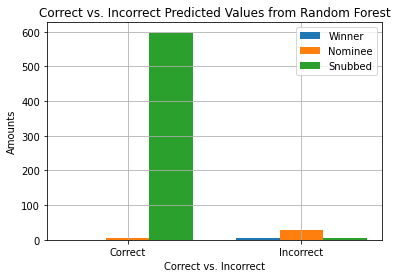

In [16]:
win_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[0]
nominee_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[1]
snubbed_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[2]
correct_win_vals = win_vals[0]
incorrect_win_vals = win_vals[1] + win_vals[2]
w_vals = [correct_win_vals, incorrect_win_vals]
correct_nom_vals = nominee_vals[1]
incorrect_nom_vals = nominee_vals[0] + nominee_vals[2]
n_vals = [correct_nom_vals, incorrect_nom_vals]
correct_snubbed_vals = snubbed_vals[2]
incorrect_snubbed_vals = snubbed_vals[1] + snubbed_vals[0]
s_vals = [correct_snubbed_vals, incorrect_snubbed_vals]
vals = ["Correct", "Incorrect"]


plot_utils.make_triple_bar_graphs(vals, w_vals, n_vals, s_vals, "Correct vs. Incorrect Predicted Values from Random Forest", "Correct vs. Incorrect", "Amounts", "Winner", "Nominee", "Snubbed")

# Random Classification - this is a control classifier 
## Figure 13: Bar Chart of y_test and predicted values of the Random Classifier

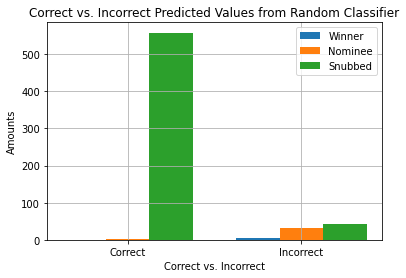

Percent Correct:  0.875


In [22]:
RandomClassifier = MyRandomClassifier()
RandomClassifier.fit(X_train, y_train)
predict_1 = RandomClassifier.predict(X_test)

win_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[0]
nominee_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[1]
snubbed_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[2]
correct_win_vals = win_vals[0]
incorrect_win_vals = win_vals[1] + win_vals[2]
w_vals = [correct_win_vals, incorrect_win_vals]
correct_nom_vals = nominee_vals[1]
incorrect_nom_vals = nominee_vals[0] + nominee_vals[2]
n_vals = [correct_nom_vals, incorrect_nom_vals]
correct_snubbed_vals = snubbed_vals[2]
incorrect_snubbed_vals = snubbed_vals[1] + snubbed_vals[0]
s_vals = [correct_snubbed_vals, incorrect_snubbed_vals]
vals = ["Correct", "Incorrect"]


plot_utils.make_triple_bar_graphs(vals, w_vals, n_vals, s_vals, "Correct vs. Incorrect Predicted Values from Random Classifier", "Correct vs. Incorrect", "Amounts", "Winner", "Nominee", "Snubbed")

percent_correct = myutils.get_percent_correct(predict_1, y_test)
print("Percent Correct: ", percent_correct)

# Zero Classification - this is a control classifier 
## Figure 13: Bar Chart of y_test and predicted values of the Zero Classifier

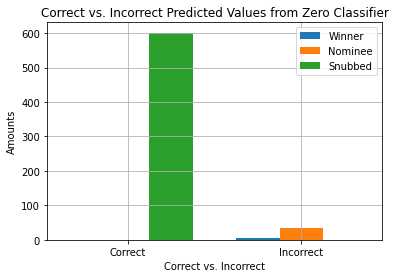

Percent Correct:  0.9390625


In [21]:
ZeroClassifier = MyZeroClassifier()
ZeroClassifier.fit(X_train, y_train)
predict_1 = ZeroClassifier.predict(X_test)

win_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[0]
nominee_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[1]
snubbed_vals = myevaluation.confusion_matrix(y_test, predict_1, ["Winner", "Nominee", "Snubbed"])[2]
correct_win_vals = win_vals[0]
incorrect_win_vals = win_vals[1] + win_vals[2]
w_vals = [correct_win_vals, incorrect_win_vals]
correct_nom_vals = nominee_vals[1]
incorrect_nom_vals = nominee_vals[0] + nominee_vals[2]
n_vals = [correct_nom_vals, incorrect_nom_vals]
correct_snubbed_vals = snubbed_vals[2]
incorrect_snubbed_vals = snubbed_vals[1] + snubbed_vals[0]
s_vals = [correct_snubbed_vals, incorrect_snubbed_vals]
vals = ["Correct", "Incorrect"]


plot_utils.make_triple_bar_graphs(vals, w_vals, n_vals, s_vals, "Correct vs. Incorrect Predicted Values from Zero Classifier", "Correct vs. Incorrect", "Amounts", "Winner", "Nominee", "Snubbed")

percent_correct = myutils.get_percent_correct(predict_1, y_test)
print("Percent Correct: ", percent_correct)

# Results and Discussion 

## Random Forest was most Successful

Of our three classifiers, Naive Bayes, Decision Tree, and Random Forest, only Random Forest beat both the Random Classifier and the Zero Classifier used as controlls. Naive Bayes only beat the Random Classifier. 
All of these classifiers appear successful, the lowest being 77% correct and the highest being 94%, because our class labels were skewed significantly. Just over 85% of the class labels were "Snubbed" with 2% being "Winner" and 12% being "Nominated".This means that even the control classifiers could do well, as guessing "Snubbed" every time would get 85% accuracy. 

## Issues with the Dataset

This dataset did not lend itself well to classification. Though we worked diligently to balance the class labels, we could not get them high enough without compromising the information significantly. In the future, we could try classifying the "Oscars" dataset we initially combined with the massive dataset of movies we found. The Oscars dataset has all nominees and winners since 1927, so the class label balance is 4:1 instead of 425:60:1. We ended up using only a handfull of attributes, duration and review information, as much of the other data would have been complex to categorize and analyze. Furthermore, nominated films and winner are more likly to have more and better reviews, as more people watch and review them after the Oscars. 

## Issues with the Classifiers

Issues with Random Forest: 
The decision tree clasifier worked well, but it would very occasionally (~1/100) predict None instead of one of the class labels. This was magnified in the Random Forest. Once I diagnosed the issue, I did not have enough time to properly fix it. I came up with a mitigating solution that would hopefully better represent the data. When the winner is chosen of all the trees in the forest, a most_frequent() function (see below) is called to get the mode result. However, the mode was None quite often. I therefore only counted labels that were not None and appended them to a list that already had "Snubbed" and "Nominee" in it. This way, if every result was None, it would select one of those two options (I did not add "Winner", as there were so few of them).  

## Member Responsibilities 

We usually worked together over long Zoom sesstions. 
Clare - Jupyter Notebook, Flask, proposal, dataset finding/cleaning
Hannah - Classifiers, Jupyter Notebook, proposal, datset finding/cleaning

In [ ]:
def most_frequent(lst):
    # deal with "none" results
    lst2 = ["Snubbed", "Nominee"]
    for i in range(len(lst)):
        if lst[i] != None:
            lst2.append(lst[i])
    return max(set(lst2), key = lst2.count)